# Covid-19 - Analysis and Modelling

Before anything. I'd like to disclose that I'm nowhere near close to an epidemiologist. But I do however enjoy math, statistics, machine learning etc. On my daily job I lead the fraud prevention intelligence team at a big fintech company. With that said, most of the studies, commentaries and conclusions in this work are the results of my professional experience with data modelling and some very shallow research, but most come from basic math and stats knowledge.

It worries me deeply that this kind of event happens in such a bad timing for humanity. We are living in the age of disinformation, which is likely one of the most hurting aspects in this entire crisis. I'm hopeful that this kind of open studies we do at Kaggle can help bring some knowledge and sense into the scene and we can either take the issue more seriously or be less anxious about it, whichever is needed at the time.

I'm thankful for beeing in a position where I'm able to contribute and I trully believe we can always make better decisions when we have data on our side. This is my attempt on helping somehow.

### Epidemics and Exponentials

Until now we can see that the spread of the disease has been following an exponential like curve, which is very common for epidemics. Some peculiarities occur, like for example, China changing protocols for counting covid-19 cases, so there is a little bit of deviation but the pattern persists.

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import seaborn as sns
import warnings

from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Package configuration #

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('../input/covid19-global-forecasting-week-1/train.csv')
test = pd.read_csv('../input/covid19-global-forecasting-week-1/test.csv')
sub = pd.read_csv('../input/covid19-global-forecasting-week-1/submission.csv')

df = pd.concat([train, test])

global_cases = train.groupby('Date')['ConfirmedCases'].sum()
global_deaths = train.groupby('Date')['Fatalities'].sum()

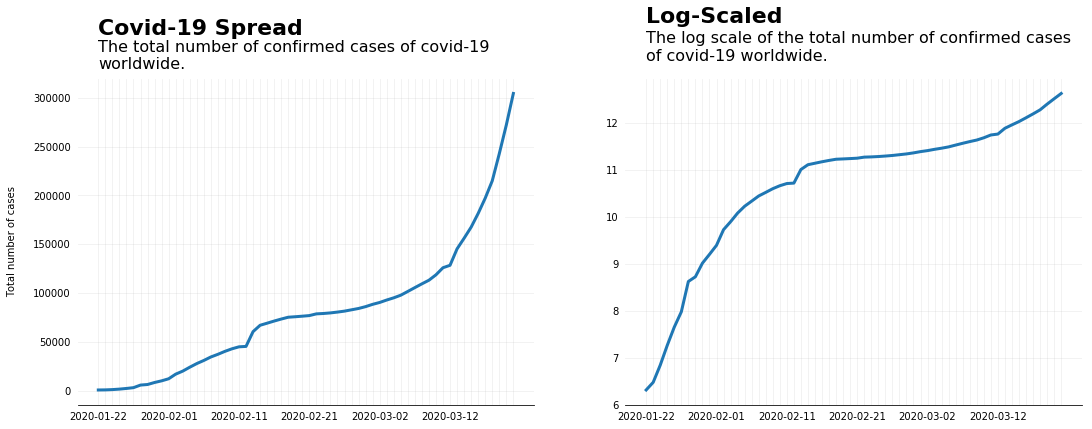

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))


## Code for plot 1 ##

sns.lineplot(x=global_cases.index, y=global_cases.values, linewidth=3, ax=ax[0])

sns.despine(top=True, left=True)

ax[0].grid(axis='both', alpha=.2)

every_nth = 10
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax[0].tick_params(axis='both', which='both', bottom=False, left=False)

ax[0].text(x=0, y=max(global_cases.values)+60000, s='Covid-19 Spread', fontsize=22, fontweight='bold')
ax[0].text(x=0, y=max(global_cases.values)+25000, s='The total number of confirmed cases of covid-19 \nworldwide.', fontsize=16)
ax[0].set_xlabel('')

ax[0].set_ylabel('Total number of cases\n')

## Code for plot 2 ##

sns.lineplot(x=global_cases.index, y=np.log(global_cases.values), linewidth=3, ax=ax[1])

sns.despine(top=True, left=True)

ax[1].grid(axis='both', alpha=.2)

every_nth = 10
for n, label in enumerate(ax[1].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax[1].tick_params(axis='both', which='both', bottom=False, left=False)

ax[1].text(x=0, y=max(np.log(global_cases.values))+1.5, s='Log-Scaled', fontsize=22, fontweight='bold')
ax[1].text(x=0, y=max(np.log(global_cases.values))+.70, s='The log scale of the total number of confirmed cases \nof covid-19 worldwide.', fontsize=16)
ax[1].set_xlabel('')

plt.show()

From the chart above, we can clearly see the exponential trend of the disease, and we can also see that the spread seemed to be slowing down a big at the beginning of march, until it began accelerating again, as can be seen in the semi-logarithmic chart on the right.

### True Exponentials Don't Exist.

In the real world, true exponentials don't exist. They are all pretty much the beggining of a logistic curve. The imporant thing when trying to understand the development of the disease is to understand if we are past or behind the inflection point.

The inflection point is the point right in the middle of the logistic curve, where the disease will start slowing down until it reaches full stop.

<br>
![image](https://www.researchgate.net/publication/236908607/figure/fig1/AS:601626985381906@1520450459171/Graph-of-logistic-curve-where-a-0-and-b-1.png)
<br>
### Growth Factor

The growth factor is the ratio between the number of cases one day and the number of cases in the previous day. It shows us if the disease is growing or not. Basically a growth factor of 1 tells us that the number of cases isn't growing, smaller than one means it's decreasing and bigger than one means it's increasing. At the inflection point, the growth factor is equal to 1.

In [4]:
g = global_cases/global_cases.shift(1)

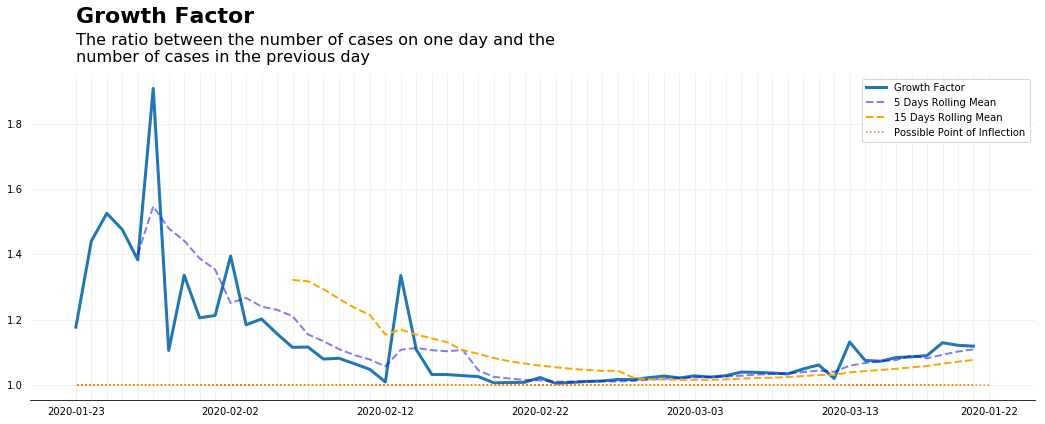

In [5]:
fig, ax = plt.subplots(figsize=(18, 6))
                       
sns.lineplot(x=g.index, y=g.values, linewidth=3, ax=ax)
sns.lineplot(x=g.index, y=g.rolling(5).mean().values, linewidth=2, ax=ax, color='blue', alpha=.5)
sns.lineplot(x=g.index, y=g.rolling(15).mean().values, linewidth=2, ax=ax, color='orange')

sns.despine(top=True, left=True)

ax.grid(axis='both', alpha=.2)

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax.tick_params(axis='both', which='both', bottom=False, left=False)

ax.text(x=0, y=max(g.fillna(0)) + .20, s='Growth Factor', fontsize=22, fontweight='bold')
ax.text(x=0, y=max(g.fillna(0)) + .08, s='The ratio between the number of cases on one day and the\nnumber of cases in the previous day', fontsize=16)

sns.lineplot(x=g.index, y=np.ones(len(g)), ax=ax)
ax.lines[1].set_linestyle('dashed')
ax.lines[2].set_linestyle('dashed')
ax.lines[3].set_linestyle(':')
ax.legend(['Growth Factor', '5 Days Rolling Mean', '15 Days Rolling Mean', 'Possible Point of Inflection'])
ax.set_xlabel('')

plt.show()

We can see in the chart that at mid february we were very close to beeing at the point of inflection but from the moving averages we can see that the trend has inverted and it's going up again. 

### Does the Line Fit?

Just as a baseline, let's see how well we can fit a basic linear regression to the data.

In [6]:
x = np.arange(0, len(global_cases)).reshape(-1, 1)
y = np.log(global_cases.values)

model = LinearRegression().fit(x, y)

print('R-Squared: %s' % model.score(x, y))

R-Squared: 0.7763009373854699


We can see that based on the logarithmic scale of the number of cases we are able to fit a regression pretty well. With a R-Squared of .77

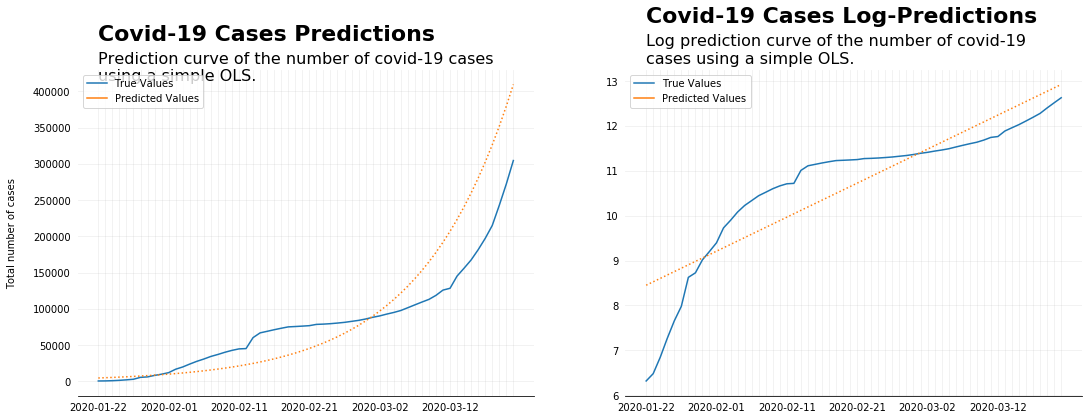

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

## Code for plot 1 ##

sns.lineplot(global_cases.index, np.exp(y), ax=ax[0])
sns.lineplot(global_cases.index, np.exp(model.predict(x)), ax=ax[0])

ax[0].grid(axis='both', alpha=.2)

sns.despine(top=True, left=True)

every_nth = 10
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax[0].text(x=0, y=470000, s='Covid-19 Cases Predictions', fontsize=22, fontweight='bold')
ax[0].text(x=0, y=415000, s='Prediction curve of the number of covid-19 cases\nusing a simple OLS.', fontsize=16)
        
ax[0].tick_params(axis='both', which='both', bottom=False, left=False)
ax[0].legend(['True Values', 'Predicted Values'])
ax[0].set_xlabel('')
ax[0].lines[1].set_linestyle(':')

ax[0].set_ylabel('Total number of cases\n')
        
## Code for plot 2 ##

sns.lineplot(global_cases.index, np.log(global_cases.values), ax=ax[1])
sns.lineplot(global_cases.index, model.predict(x), ax=ax[1])

ax[1].grid(axis='both', alpha=.2)

sns.despine(top=True, left=True)

every_nth = 10
for n, label in enumerate(ax[1].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax[1].text(x=0, y=14.3, s='Covid-19 Cases Log-Predictions', fontsize=22, fontweight='bold')
ax[1].text(x=0, y=13.4, s='Log prediction curve of the number of covid-19\ncases using a simple OLS.', fontsize=16)
        
ax[1].tick_params(axis='both', which='both', bottom=False, left=False)
ax[1].legend(['True Values', 'Predicted Values'])
ax[1].set_xlabel('')
ax[1].lines[1].set_linestyle(':')

plt.show()

### Medium Term Predictions

Let's use a model to try to estimate what the number of cases will be in the medium term.

In [8]:
x_2 = np.arange(0, 79).reshape(-1, 1)

predictions = model.predict(x_2)

In [9]:
first_date = pd.to_datetime(min(global_cases.index))
last_date =  (first_date + timedelta(days=78)).strftime('%Y-%m-%d')
first_date = first_date.strftime('%Y-%m-%d')
index = pd.date_range(first_date, last_date)

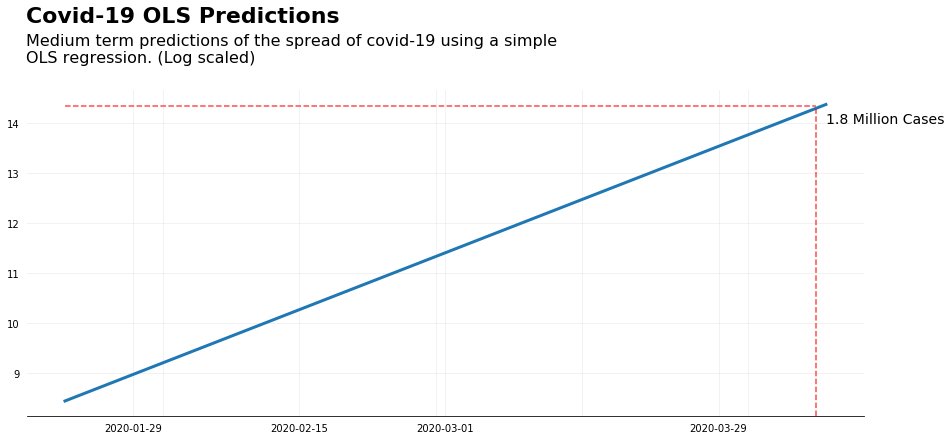

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
                       
sns.lineplot(x=index, y=predictions, linewidth=3)

sns.despine(top=True, left=True)

ax.grid(axis='both', alpha=.2)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax.tick_params(axis='both', which='both', bottom=False, left=False)

ax.text(x='2020-01-18', y=16, fontsize=22, fontweight='bold', s='Covid-19 OLS Predictions')
ax.text(x='2020-01-18', y=15.2, fontsize=16, s='Medium term predictions of the spread of covid-19 using a simple\nOLS regression. (Log scaled)')

ax.axvline(x='2020-04-08', ymin=0,ymax=.94, linestyle='dashed', color='red', alpha=.7)
ax.hlines(y=14.34, xmin='2020-01-22', xmax='2020-04-08', linestyle='dashed', color='red', alpha=.7)
ax.text(x='2020-04-09', y=14, s='1.8 Million Cases', fontsize=14)

plt.show()

Our linear regression model predicts that in 20 days we'll have almost **1.8 million people infected**. This is obviously a very simple linear regression model using some very basic data. We could surely do a much better job using other features like, total population, infection probability etc. The model also doesn't take into consideration the measures taken by governments to reduce the spread of the infection and obviously it also doesn't take into account the development of medicine and vaccination.

# WIP

### TODO

- Add more features (external) to the dataset;
- Make prediction on fatalities;
- Draw insights from features correlation with the spread of the disease;
- Sugestions?

Thanks for reading! Upvote if you enjoyed >.<